In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('train_set_100.csv',encoding='utf-8')
df['labels'] = pd.factorize(df.mahkemes)[0]
df.head()

,ictihats,mahkemes,labels
0,basit yarala suç 5237 türk ceza kanun 862 863e...,undefined,0
1,taraf görüle dava mahkemeç kabul karar veril h...,asliye hukuk mahkemesi,1
2,5237 53 5271 288 289 294 299 302 any mah 08102...,undefined,0
3,bölge hukuk daires taraf görüle dav sonuç veri...,undefined,0
4,taraf görüle dava 311 357 770 parsel miras mal...,bolge adliye mahkemesi,2


In [3]:
X = df.ictihats.astype(str)
Y = df.labels
le = LabelEncoder()
Y = to_categorical(Y)


In [4]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [5]:
max_words = 150000
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = keras.utils.pad_sequences(sequences,maxlen=max_len)

In [6]:
tok_test = Tokenizer(num_words=max_words)
tok_test.fit_on_texts(X_test)
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = keras.utils.pad_sequences(sequences_test,maxlen=max_len)

In [7]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(10,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [8]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 50)           7500000   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 10)                2570  

In [9]:
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=30,
          validation_split=0.2)

Epoch 1/30
279/279 [==============================] - 63s 220ms/step - loss: 0.2464 - accuracy: 0.4768 - val_loss: 0.1812 - val_accuracy: 0.6109
Epoch 2/30
279/279 [==============================] - 64s 230ms/step - loss: 0.1600 - accuracy: 0.6782 - val_loss: 0.1334 - val_accuracy: 0.7444
Epoch 3/30
279/279 [==============================] - 66s 237ms/step - loss: 0.1135 - accuracy: 0.7837 - val_loss: 0.1141 - val_accuracy: 0.7933
Epoch 4/30
279/279 [==============================] - 66s 237ms/step - loss: 0.0913 - accuracy: 0.8288 - val_loss: 0.0983 - val_accuracy: 0.8205
Epoch 5/30
279/279 [==============================] - 66s 236ms/step - loss: 0.0793 - accuracy: 0.8547 - val_loss: 0.0974 - val_accuracy: 0.8326
Epoch 6/30
279/279 [==============================] - 66s 236ms/step - loss: 0.0699 - accuracy: 0.8749 - val_loss: 0.0871 - val_accuracy: 0.8402
Epoch 7/30
279/279 [==============================] - 66s 237ms/step - loss: 0.0630 - accuracy: 0.8912 - val_loss: 0.0822 - val_ac

In [10]:
y_pred = model.predict(sequences_matrix_test)

175/175 [==============================] - 8s 44ms/step


In [11]:
def convertPredicts(y_pred):
    new_y_pred = []
    for i in range(len(y_pred)):
        pred_row = y_pred[i]
        #print(pred_row)
        max_index = np.argmax(pred_row, axis=0)
        new_row = [0] * 10
        new_row[max_index] = 1
        new_y_pred.append(new_row)

    return new_y_pred

y_pred = convertPredicts(y_pred) 

In [12]:
target_names = df.mahkemes.unique()
target_names
print(classification_report(Y_test, y_pred, target_names=target_names))

                        precision    recall  f1-score   support

             undefined       0.97      0.98      0.98      1304
asliye hukuk mahkemesi       0.78      0.77      0.77       363
bolge adliye mahkemesi       0.93      0.93      0.93       497
     ticaret mahkemesi       0.64      0.40      0.49        63
                 other       0.68      0.60      0.64       280
          is mahkemesi       0.86      0.95      0.90       265
 asliye ceza mahkemesi       0.89      0.94      0.92      2046
          ceza dairesi       0.91      0.94      0.93       200
       cocuk mahkemesi       0.62      0.48      0.54       174
   agir ceza mahkemesi       0.75      0.64      0.69       379

             micro avg       0.88      0.88      0.88      5571
             macro avg       0.80      0.76      0.78      5571
          weighted avg       0.87      0.88      0.88      5571
           samples avg       0.88      0.88      0.88      5571



In [13]:
def transform1d(test, pred):
    pred_new = []
    for i in range(0, len(pred)):
        for j in range(0,10):
            if(pred[i][j] == 1 or pred[i][j] == True):
                pred_new.append(j) 

    test_new = []
    for i in range(0, len(test)):
        for j in range(0,10):
            if(test[i][j] == 1):
                test_new.append(j) 
    return [test_new, pred_new]

[test_new, pred_new] = transform1d(Y_test, y_pred)
print(pred_new[:20])
print(test_new[:20])


[0, 5, 6, 6, 0, 6, 1, 9, 1, 4, 2, 6, 0, 0, 1, 6, 9, 6, 0, 9]
[0, 5, 6, 6, 0, 6, 1, 9, 1, 3, 2, 6, 0, 0, 1, 4, 6, 6, 0, 9]


In [14]:
print("Accuracy:", accuracy_score(test_new, pred_new))

Accuracy: 0.8799138395261173


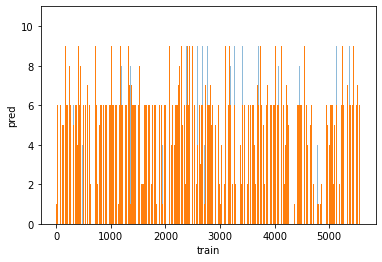

In [15]:
plt.ylim(0,11)
plt.bar(range(len(test_new)), test_new, alpha = 0.5)
plt.bar(range(len(pred_new)), pred_new)
plt.xlabel("train")
plt.ylabel("pred")

plt.show()

[[1280    1    7    1    5    2    4    2    0    2]
 [   4  279   12    9   37    9    1    3    8    1]
 [   9    9  461    3   11    3    0    1    0    0]
 [   4   23    1   25    6    1    0    2    0    1]
 [  13   30   12    0  168   13   39    2    2    1]
 [   5    4    1    0    2  251    1    1    0    0]
 [   2    1    0    0   12    8 1922    2   35   64]
 [   2    0    0    0    2    1    1  189    0    5]
 [   0   10    4    1    0    2   65    0   83    9]
 [   2    1    0    0    3    1  118    5    5  244]]


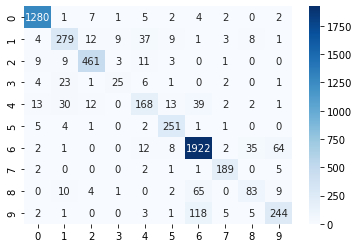

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(test_new, pred_new)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

